<a href="https://colab.research.google.com/github/karim-mammadov/SaiKet_Systems_Tasks/blob/main/Task_3_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Load Dataset**

In [3]:
df = pd.read_csv("/content/Telco_Customer_Churn_Dataset  (3).csv")
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

**Drop Irrelevant Columns**

In [4]:
df = df.drop("customerID", axis=1)
print("Dropped 'customerID' column.")

Dropped 'customerID' column.


**Handle Missing Values**

**Convert 'TotalCharges' to numeric**

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

**Fill numeric missing values with median**

In [6]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

**Fill categorical missing values with mode**

In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
print("Handled missing values.")

Handled missing values.


**Encode Categorical Variables**

**Exclude target**

In [8]:
categorical_cols = [col for col in categorical_cols if col != 'Churn']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

**Encode target**

In [9]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("Encoded categorical variables and target.")

Encoded categorical variables and target.


**Customer Segmentation**

**We segment based on tenure, MonthlyCharges, and contract type**

**Bin tenure into categories**

In [10]:
df['tenure_group'] = pd.cut(df['tenure'],
                            bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12','13-24','25-48','49-60','61-72'])

**Bin MonthlyCharges into categories**

In [11]:
df['MonthlyCharges_group'] = pd.qcut(df['MonthlyCharges'], q=4, labels=['Low','Medium','High','Very High'])

**Extract contract type from one-hot columns**

In [12]:
contract_cols = [col for col in df.columns if 'Contract_' in col]
def get_contract_type(row):
    for col in contract_cols:
        if row[col] == 1:
            return col.replace('Contract_', '')
    return 'Unknown'

In [13]:
df['ContractType'] = df.apply(get_contract_type, axis=1)
print("Created customer segments based on tenure, MonthlyCharges, and contract type.")

Created customer segments based on tenure, MonthlyCharges, and contract type.


**Analyze Churn Within Segments**

In [16]:
churn_summary = df.groupby(['tenure_group','MonthlyCharges_group','ContractType'], observed=False)['Churn'].mean().reset_index()
churn_summary.rename(columns={'Churn':'ChurnRate'}, inplace=True)
print(churn_summary.head())

  tenure_group MonthlyCharges_group ContractType  ChurnRate
0         0-12                  Low     One year   0.060976
1         0-12                  Low     Two year   0.000000
2         0-12                  Low      Unknown   0.297297
3         0-12               Medium     One year   0.178571
4         0-12               Medium     Two year   0.000000


**Identify High-Value Customers at Risk**

**Criteria: High MonthlyCharges and Churn = 1**

In [17]:
high_value_risk = df[(df['MonthlyCharges_group'].isin(['High','Very High'])) & (df['Churn'] == 1)]
print("Number of high-value customers at risk:", high_value_risk.shape[0])

Number of high-value customers at risk: 1237


**Visualization**

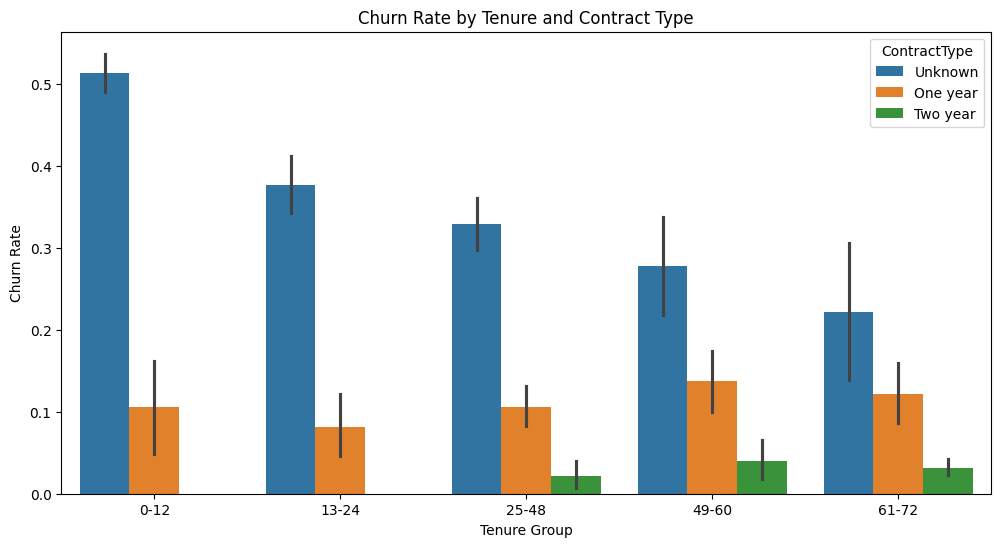

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(x='tenure_group', y='Churn', hue='ContractType', data=df)
plt.title("Churn Rate by Tenure and Contract Type")
plt.ylabel("Churn Rate")
plt.xlabel("Tenure Group")
plt.show()